In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
# %matplotlib notebook

import logging
logging.basicConfig(level=logging.INFO)
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

import superscreen as sc

In [2]:
def rotate(points, degrees):
    c = np.cos(np.radians(degrees))
    s = np.sin(np.radians(degrees))
    R = np.array([[c, -s], [s, c]])
    return (R @ points.T).T

In [3]:
def huber_geometry(interp_points=101):
    ri_pl = 1.8
    ro_pl = 2.7
    w_pl_center = 1.18
    w_pl_outer = 3.10
    pl_angle = 0
    pl_total_length = 15
    y0_pl_leads = -(pl_total_length - ro_pl)

    x0_pl_center = w_pl_center / 2
    theta0_pl_center = np.arcsin(x0_pl_center / ri_pl)
    y0_pl_center = ri_pl * np.cos(theta0_pl_center)
    thetas_pl_center = np.linspace(theta0_pl_center, 2*np.pi - theta0_pl_center, 101) - np.pi/2

    x0_pl_outer = w_pl_outer / 2
    theta0_pl_outer = np.arcsin(x0_pl_outer / ro_pl)
    y0_pl_outer = ro_pl * np.cos(theta0_pl_outer)
    thetas_pl_outer = np.linspace(theta0_pl_outer, 2*np.pi - theta0_pl_outer, 101) - np.pi/2
    
    pl_points = np.concatenate([
        [[-w_pl_outer / 2, y0_pl_leads]],
        ro_pl * np.stack([np.cos(thetas_pl_outer), np.sin(thetas_pl_outer)], axis=1)[::-1],
        [[w_pl_outer / 2, y0_pl_leads]],
        [[w_pl_center / 2, y0_pl_leads]],
        ri_pl * np.stack([np.cos(thetas_pl_center), np.sin(thetas_pl_center)], axis=1),
        [[-w_pl_center / 2, y0_pl_leads]],
        [[-w_pl_outer / 2, y0_pl_leads]],
    ])
    pl_points = rotate(pl_points, pl_angle)
    
    
    pl_shield = np.concatenate([
        [[-(w_pl_outer/2 + 0.25), -(ri_pl + 0.5)]],
        [[-w_pl_outer/2, -(ri_pl + 0.25)]],
        [[+w_pl_outer/2, -(ri_pl + 0.25)]],
        [[+(w_pl_outer/2 + 0.25), -(ri_pl + 0.5)]],
        [[+(w_pl_outer/2 + 0.25), y0_pl_leads - 0.5]],
        [[-(w_pl_outer/2 + 0.25), y0_pl_leads - 0.5]],
        [[-(w_pl_outer/2 + 0.25), -(ri_pl + 0.5)]],
    ])
    pl_shield = rotate(pl_shield, pl_angle)
    
    pl_hull = np.concatenate([
        [[-w_pl_outer / 2, y0_pl_leads]],
        ro_pl * np.stack([np.cos(thetas_pl_outer), np.sin(thetas_pl_outer)], axis=1)[::-1],
        [[w_pl_outer / 2, y0_pl_leads]],
        [[w_pl_center / 2, y0_pl_leads]],
        [[-w_pl_center / 2, y0_pl_leads]],
        [[-w_pl_outer / 2, y0_pl_leads]],
    ])
    pl_hull = rotate(pl_hull, pl_angle)


    ri_fc = 5.5
    ro_fc = 8.0
    w_fc_outer = 7.0
    w_fc_center = 1.6
    fc_angle = 45
    
    fc_center_length = 6
    y0_fc_center_leads = -(fc_center_length + ri_fc)
    
    x0_fc_center = w_fc_center / 2
    theta0_fc_center = np.arcsin(x0_fc_center / ri_fc)
    y0_fc_center = ri_fc * np.cos(theta0_fc_center)
    thetas_fc_center = np.linspace(theta0_fc_center, 2*np.pi - theta0_fc_center, 101) - np.pi/2
    
    fc_center_points = np.concatenate([
        [[-w_fc_center / 2, y0_fc_center_leads]],
        ri_fc * np.stack([np.cos(thetas_fc_center), np.sin(thetas_fc_center)], axis=1)[::-1],
        [[w_fc_center / 2, y0_fc_center_leads]],
        [[-w_fc_center / 2, y0_fc_center_leads]],
    ])
    fc_center_points = rotate(fc_center_points, fc_angle)
    
    fc_outer_length = 6
    y0_fc_outer_leads = -(fc_outer_length + ro_fc)
    
    x0_fc_outer = w_fc_outer / 2
    theta0_fc_outer = np.arcsin(x0_fc_outer / ro_fc)
    y0_fc_outer = ri_fc * np.cos(theta0_fc_outer)
    thetas_fc_outer = np.linspace(theta0_fc_outer, 2*np.pi - theta0_fc_outer, 101) - np.pi/2
    
    fc_outer_points = np.concatenate([
        [[-w_fc_outer / 2, y0_fc_outer_leads]],
        ro_fc * np.stack([np.cos(thetas_fc_outer), np.sin(thetas_fc_outer)], axis=1)[::-1],
        [[w_fc_outer / 2, y0_fc_outer_leads]],
        [[-w_fc_outer / 2, y0_fc_outer_leads]],
    ])
    fc_outer_points = rotate(fc_outer_points, fc_angle)
    
    w_fc_shield = 10
    w0_fc_shield = 2
    y0_fc_shield = -(ro_fc + 1)
    y1_fc_shield = -(ri_fc - 0.5)
    
    fc_shield = np.concatenate([
        [[-w_fc_shield/2, y0_fc_outer_leads - 1]],
        [[-w_fc_shield/2, y0_fc_shield]],
        [[-w0_fc_shield/2, y1_fc_shield]],
        [[+w0_fc_shield/2, y1_fc_shield]],
        [[+w_fc_shield/2, y0_fc_shield]],
        [[+w_fc_shield/2, y0_fc_outer_leads - 1]],
        [[-w_fc_shield/2, y0_fc_outer_leads - 1]],
    ])
    fc_shield = rotate(fc_shield, fc_angle)
    
    polygons = {
        "pl": pl_points,
        "pl_hull": pl_hull,
        "pl_shield": pl_shield,
        "fc": fc_outer_points,
        "fc_center": fc_center_points,
        "fc_shield": fc_shield,
    }
    
    if interp_points is not None:
        new_polygons = {}
        for name, points in polygons.items():
            x, y = np.array(points).T
            tck, u = splprep([x, y], s=0, k=1)
            new_points = splev(np.linspace(0, 1, interp_points), tck)
            new_polygons[name] = np.stack(new_points, axis=1)
        polygons = new_polygons
    
    return polygons


def huber_squid(interp_points=None):
    # See Nick Koshnick thesis
    # bottom of page 29 and table 3.2 on page 32).

    d_be = 0.2
    d_i1 = 0.350
    d_w1 = 0.23
    d_i2 = 0.350
    d_w2 = 0.25

    z0_w2 = d_w2 / 2
    z0_w1 = z0_w2 + d_w2 / 2 + d_i2 + d_w1 / 2
    z0_be = d_w2 + d_i2 + d_w1 + d_i1 + d_be / 2
    
    polygons = huber_geometry(interp_points=interp_points)

    layers = [
#         sc.Layer("BE", london_lambda=0.08, thickness=d_be, z0=z0_be),
        sc.Layer("BE", london_lambda=10, thickness=d_be, z0=z0_be),
        sc.Layer("W1", london_lambda=0.08, thickness=d_w1, z0=z0_w1),
        sc.Layer("W2", london_lambda=0.08, thickness=d_w2, z0=z0_w2),
    ]

    films = [
        sc.Polygon("fc", layer="BE", points=polygons["fc"]),
        # sc.Polygon("fc_shield", layer="W1", points=polygons["fc_shield"]),
        sc.Polygon("pl", layer="W1", points=polygons["pl"]),
        sc.Polygon("pl_shield", layer="W2", points=polygons["pl_shield"]),
    ]

    holes = [
        sc.Polygon("fc_center", layer="BE", points=polygons["fc_center"]),
    ]

    bbox = np.array([
        [-9.0, -13.5],
        [-9.0,   9.0],
        [13.0,   9.0],
        [13.0, -13.5],
    ])

    abstract_regions = [
        sc.Polygon("bounding_box", layer="BE", points=bbox),
        sc.Polygon("pl_hull", layer="W1", points=polygons["pl_hull"]),
    ]
    
    device = sc.Device(
        "huber_squid",
        layers=layers,
        films=films,
        holes=holes,
        abstract_regions=abstract_regions,
        length_units="um",
    )
    return device

In [4]:
device = huber_squid(101)

In [5]:
device.make_mesh(min_triangles=10000, optimesh_steps=200)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 10000 triangles.
INFO:superscreen.device:Finished generating mesh with 5125 points and 10000 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


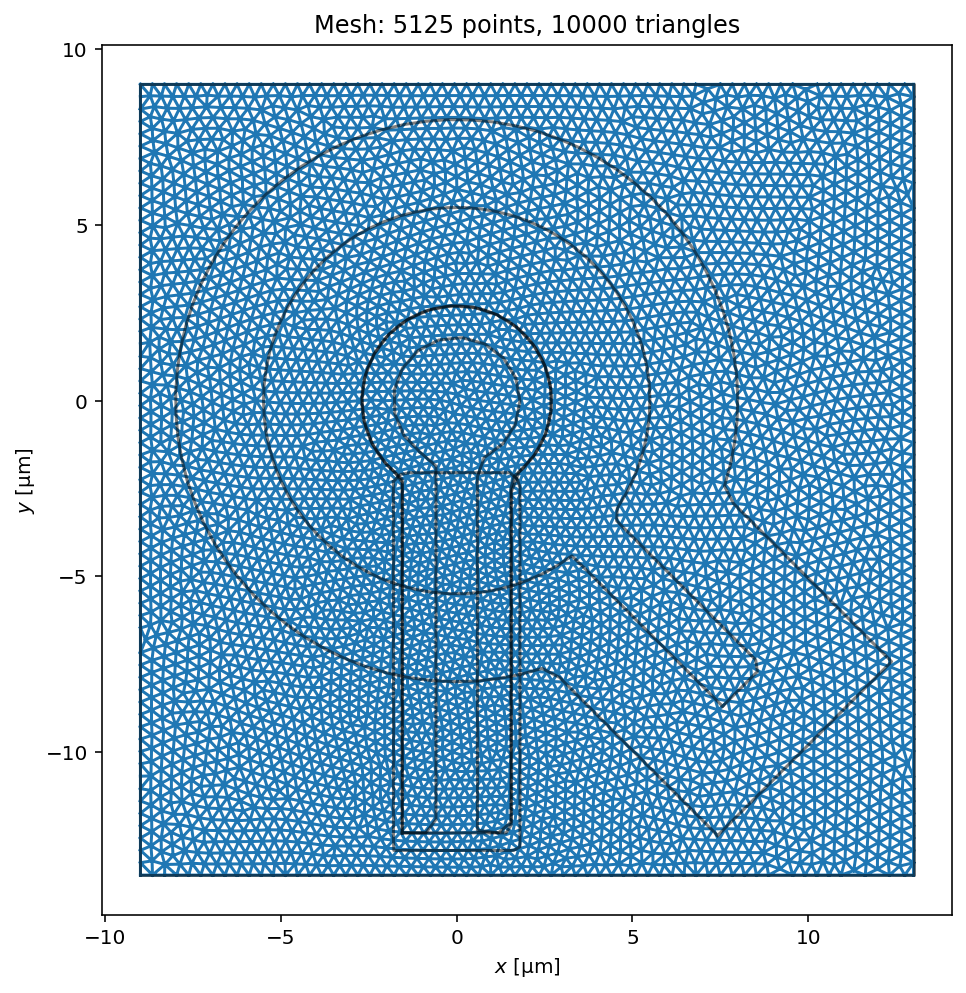

In [6]:
ax = device.plot_mesh()
ax = device.plot_polygons(ax=ax, color='k', alpha=0.5, legend=False)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, "
    f"{device.triangles.shape[0]} triangles"
)
ax.figure.set_size_inches(8,8)

In [7]:
applied_field = sc.sources.ConstantField(0.0)

circulating_currents = {
    "fc_center": "1 mA"
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="Phi_0/um**2",
    current_units="uA",
    iterations=11,
    coupled=True,
)
solution = solutions[-1]

INFO:superscreen.brandt:Calculating BE response to applied field.
INFO:superscreen.brandt:Calculating W1 response to applied field.
INFO:superscreen.brandt:Calculating W2 response to applied field.
INFO:superscreen.brandt:Calculating screening field at BE from W1 (1/11).
INFO:superscreen.brandt:Calculating screening field at BE from W2 (1/11).
INFO:superscreen.brandt:Calculating screening field at W1 from BE (1/11).
INFO:superscreen.brandt:Calculating screening field at W1 from W2 (1/11).
INFO:superscreen.brandt:Calculating screening field at W2 from BE (1/11).
INFO:superscreen.brandt:Calculating screening field at W2 from W1 (1/11).
INFO:superscreen.brandt:Calculating BE response to applied field and screening field from other layers (1/11).
INFO:superscreen.brandt:Calculating W1 response to applied field and screening field from other layers (1/11).
INFO:superscreen.brandt:Calculating W2 response to applied field and screening field from other layers (1/11).
INFO:superscreen.brandt:C

INFO:superscreen.brandt:Calculating screening field at W2 from W1 (10/11).
INFO:superscreen.brandt:Calculating BE response to applied field and screening field from other layers (10/11).
INFO:superscreen.brandt:Calculating W1 response to applied field and screening field from other layers (10/11).
INFO:superscreen.brandt:Calculating W2 response to applied field and screening field from other layers (10/11).
INFO:superscreen.brandt:Calculating screening field at BE from W1 (11/11).
INFO:superscreen.brandt:Calculating screening field at BE from W2 (11/11).
INFO:superscreen.brandt:Calculating screening field at W1 from BE (11/11).
INFO:superscreen.brandt:Calculating screening field at W1 from W2 (11/11).
INFO:superscreen.brandt:Calculating screening field at W2 from BE (11/11).
INFO:superscreen.brandt:Calculating screening field at W2 from W1 (11/11).
INFO:superscreen.brandt:Calculating BE response to applied field and screening field from other layers (11/11).
INFO:superscreen.brandt:Cal

In [8]:
records = []
for s in solutions:
    records.append(s.polygon_flux(units="Phi_0", with_units=False))
df = pd.DataFrame.from_records(records)
df.index.name = "Iteration"

In [9]:
display(df)

,fc,pl,pl_shield,fc_center,bounding_box,pl_hull
Iteration,,,,,,
0,7.323236,0.000000,0.000000,3.872115,6.855887,0.000000
1,7.323236,0.298208,0.062879,3.872115,6.855887,1.115720
2,7.074101,0.257183,0.053935,3.612546,6.778559,0.949881
3,7.124376,0.265170,0.056355,3.661338,6.786248,0.963205
4,7.105688,0.261475,0.055720,3.643604,6.783466,0.955409
5,7.111729,0.262228,0.055966,3.649308,6.784054,0.956777
6,7.109536,0.261874,0.055909,3.647297,6.783882,0.956129
7,7.110273,0.261946,0.055933,3.647963,6.783909,0.956249
8,7.110003,0.261912,0.055928,3.647727,6.783904,0.956194


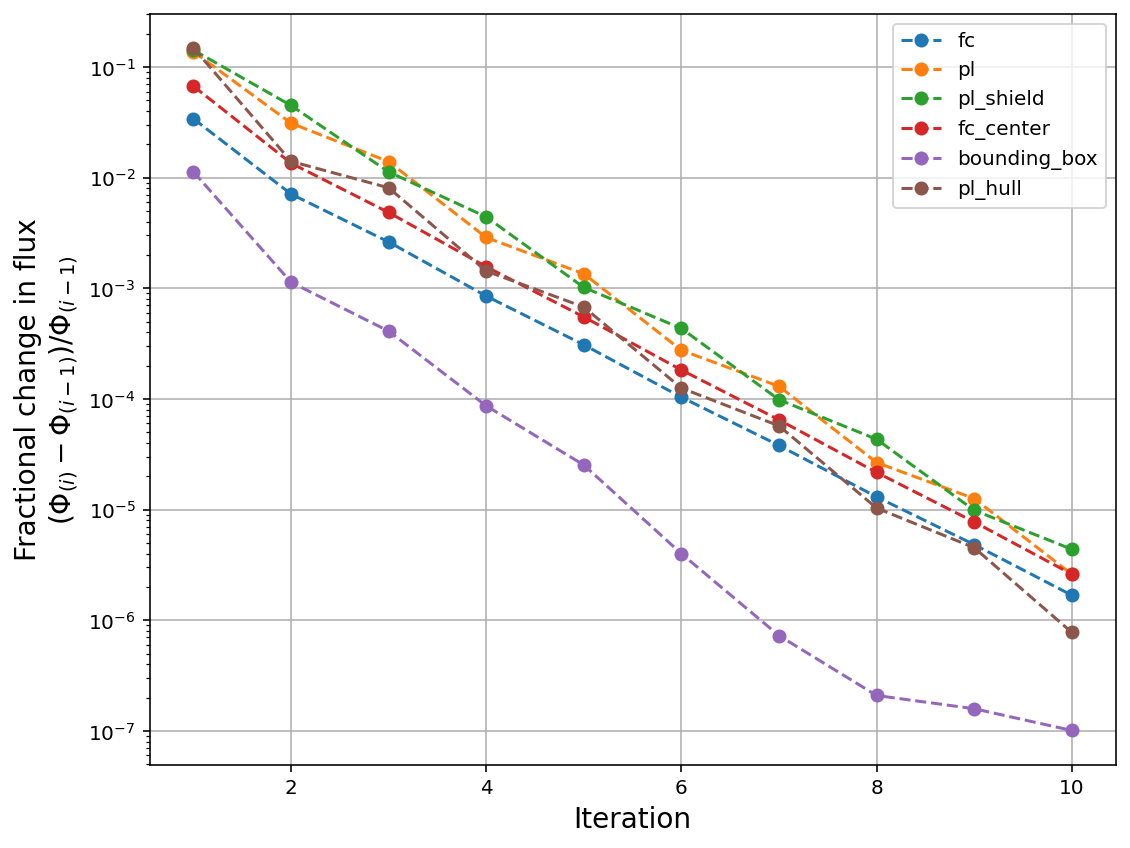

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
for col in df.columns:
    ys = df[col].values
    ys = np.abs(np.diff(ys))[1:] / np.abs(ys)[1:-1]
    ax.plot(np.arange(len(ys)) + 1, ys, 'o--', label=col)
ax.set_ylabel("Fractional change in flux\n$(\\Phi_{(i)} -\\Phi_{(i-1)}) / \\Phi_{(i-1)}$", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_yscale("log")
ax.legend(loc=0)
fig.tight_layout()

In [11]:
flux = solutions[-1].polygon_flux()
print(f"{flux['pl_hull'].to('Phi_0'):.3e~P}")
print(f"{(flux['pl_hull'] / device.ureg(circulating_currents['fc_center'])).to('Phi_0/A'):.3f~P}")

9.562×10⁻¹ Φ_0
956.201 Φ_0/A


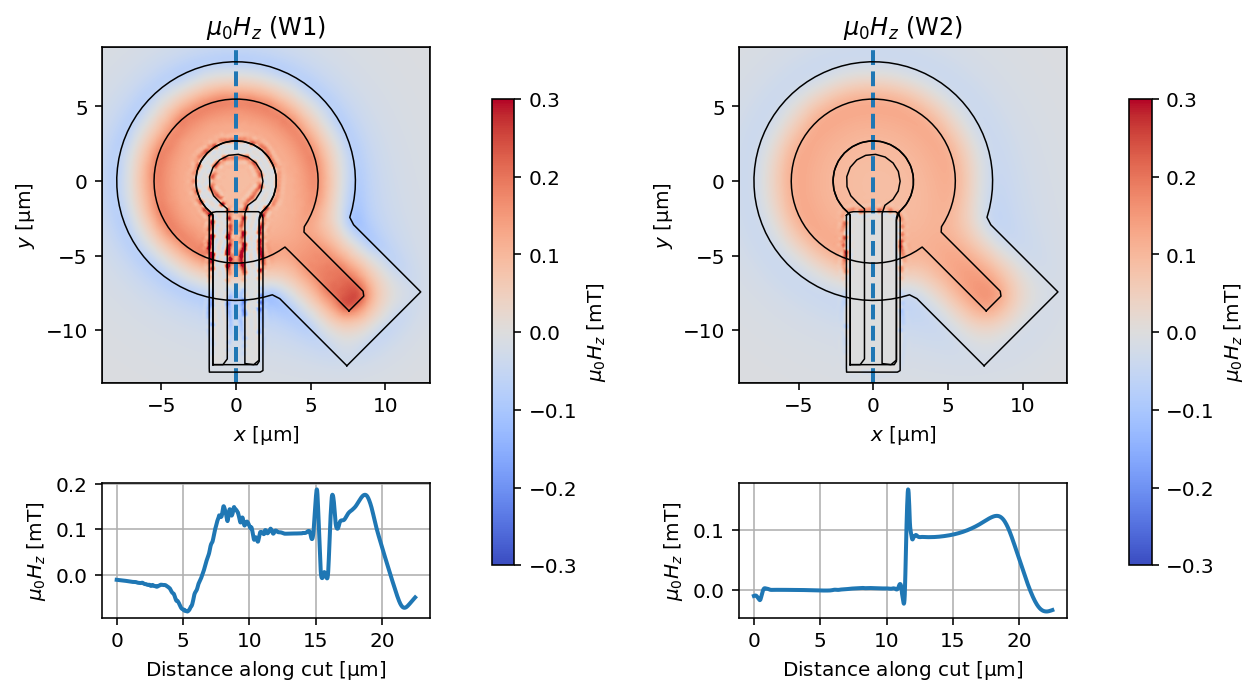

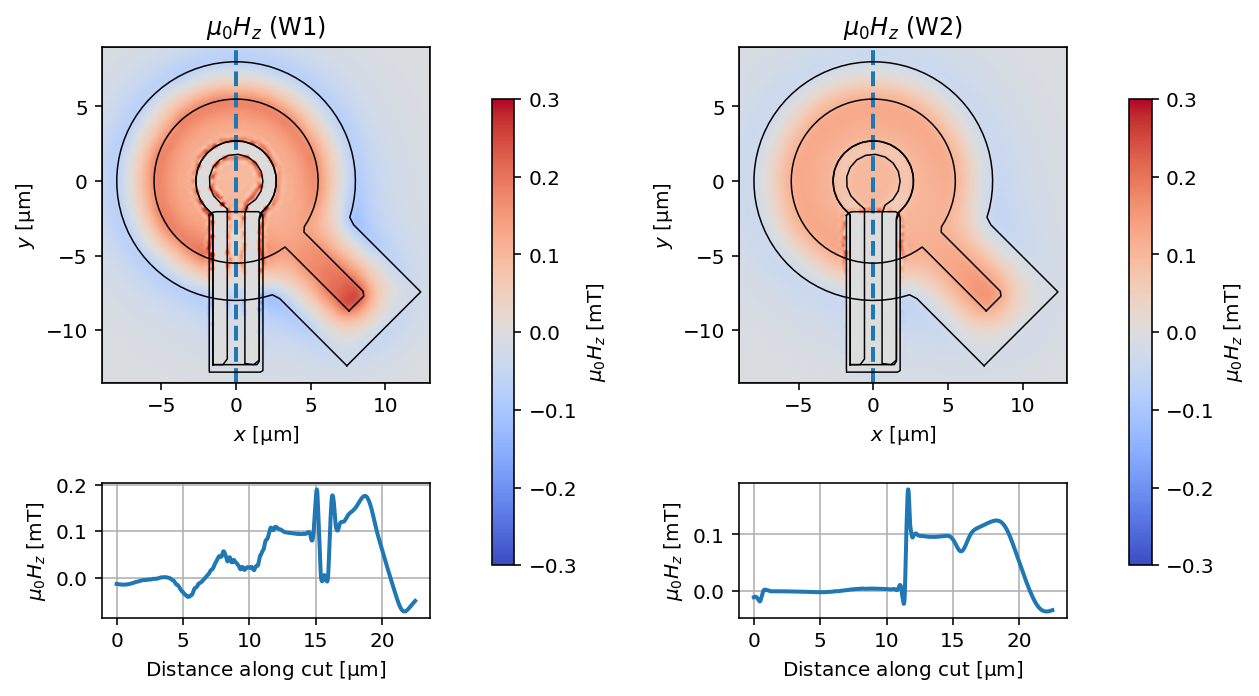

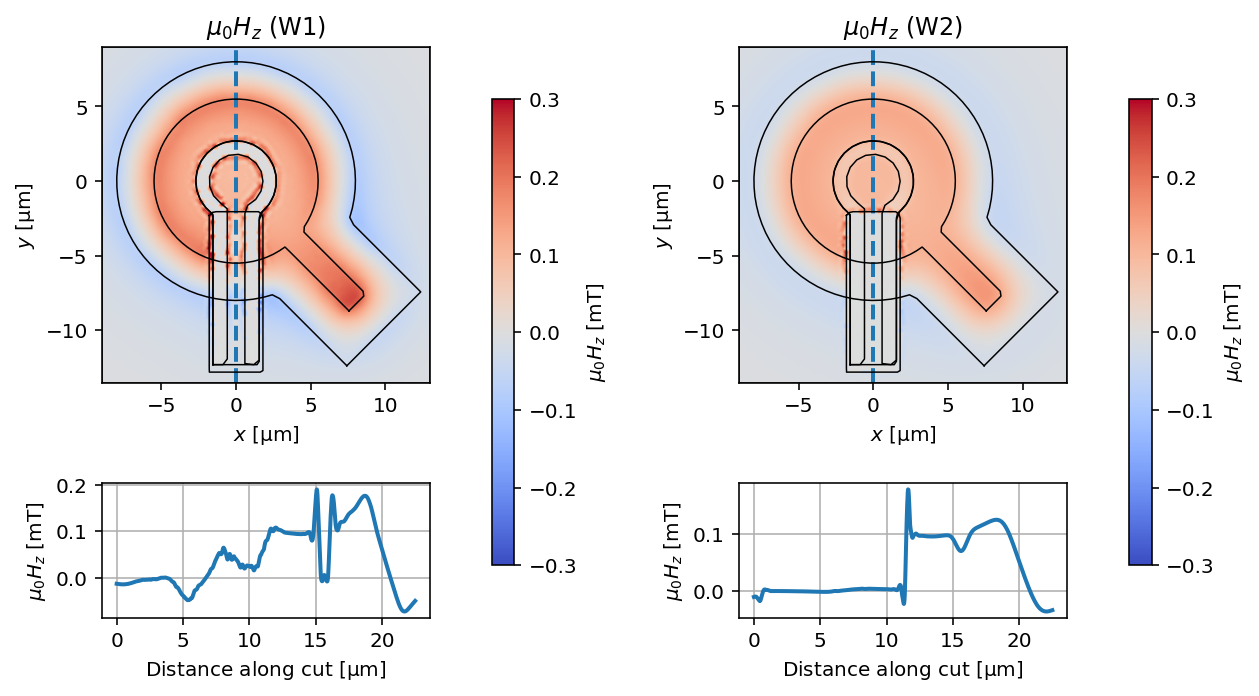

In [12]:
for solution in solutions[1:4]:
    fig, axes = sc.plot_fields(
        solution,
        layers=["W1", "W2"],
        units="mT",
        cmap="coolwarm",
        figsize=(9,5),
        grid_shape=(1000, 1000),
        cross_section_xs=0,
        cross_section_angle=0,
        vmin=-0.3, vmax=0.3,
    )
    for ax in axes:
        device.plot_polygons(ax=ax, legend=False, color='k', lw=0.75)

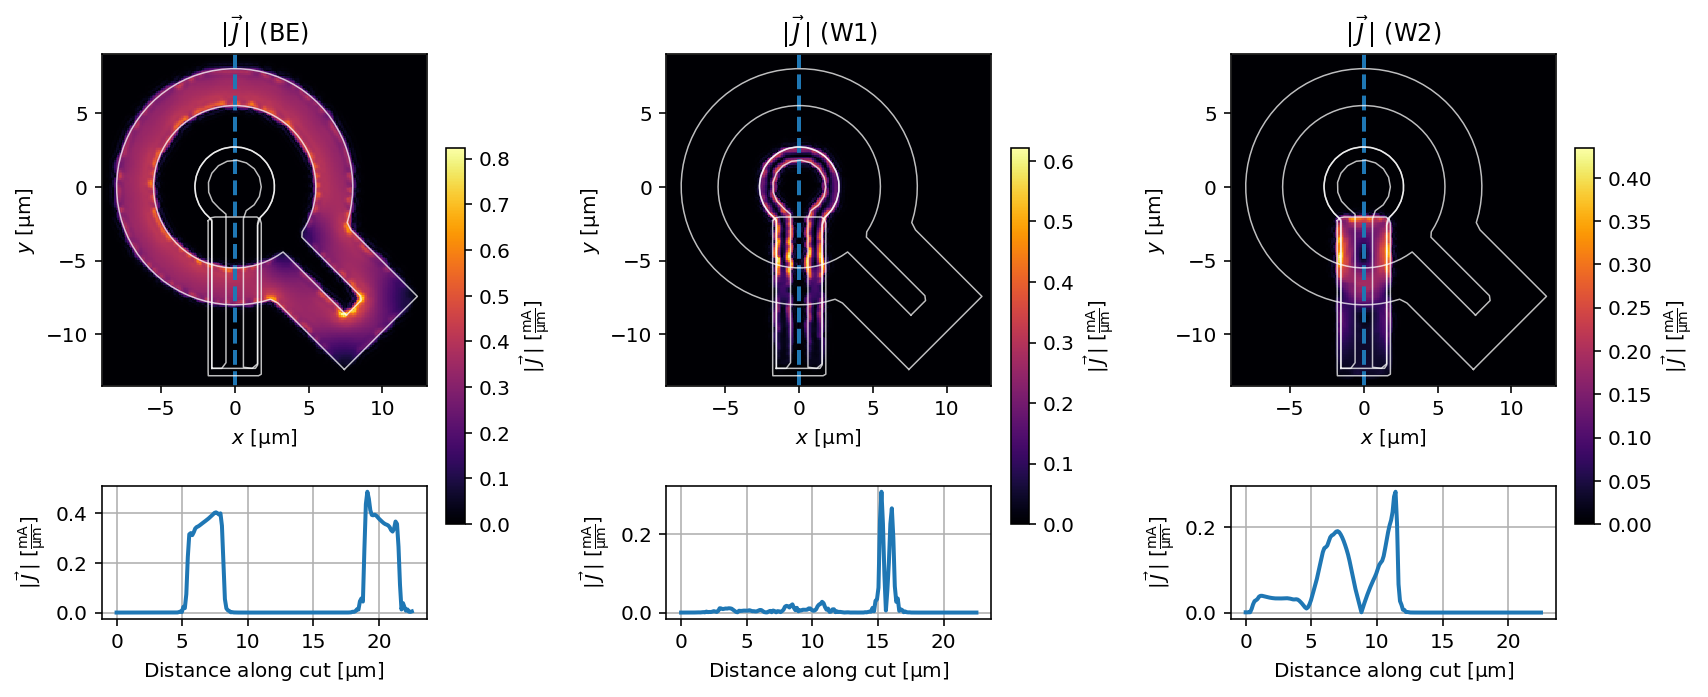

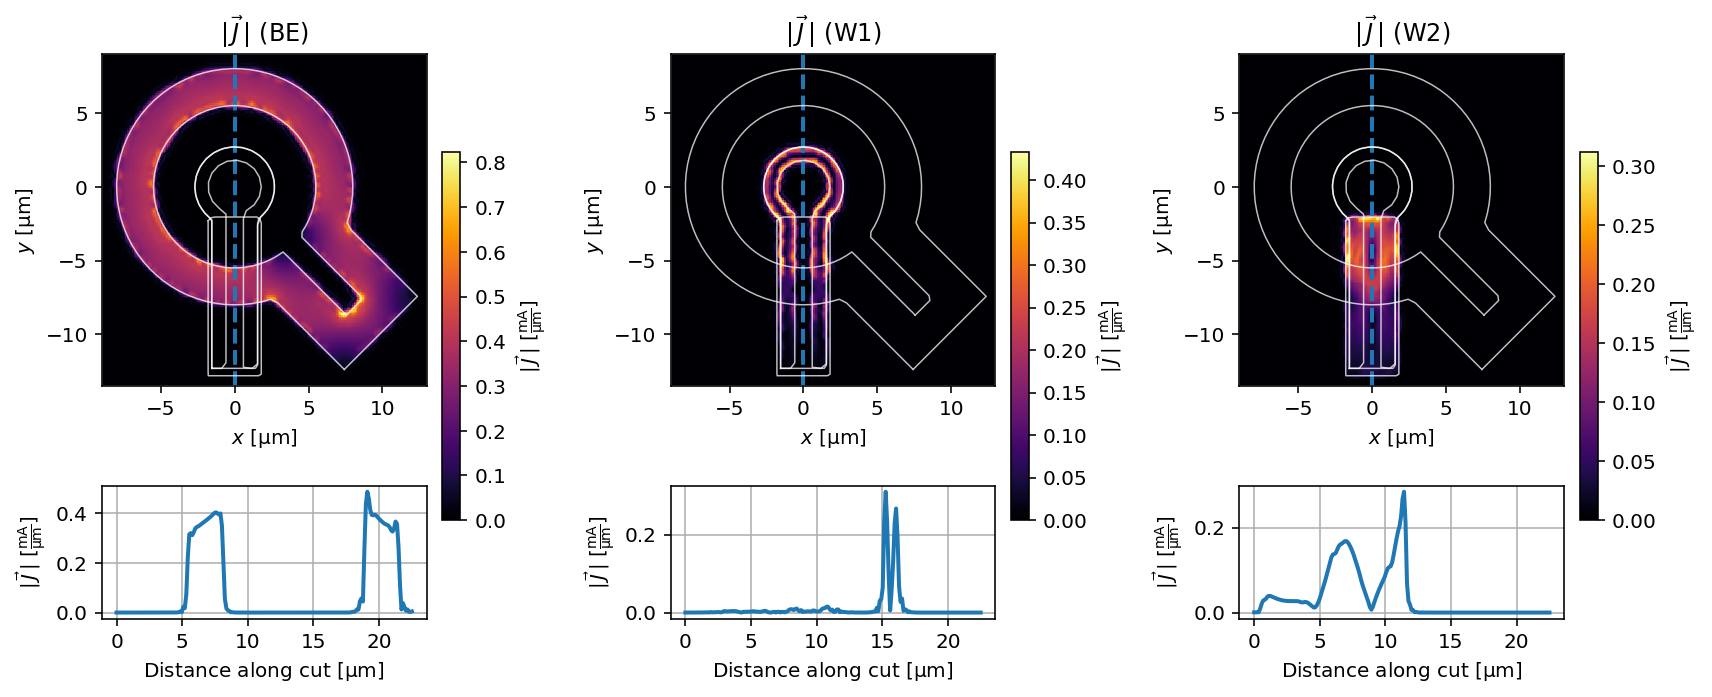

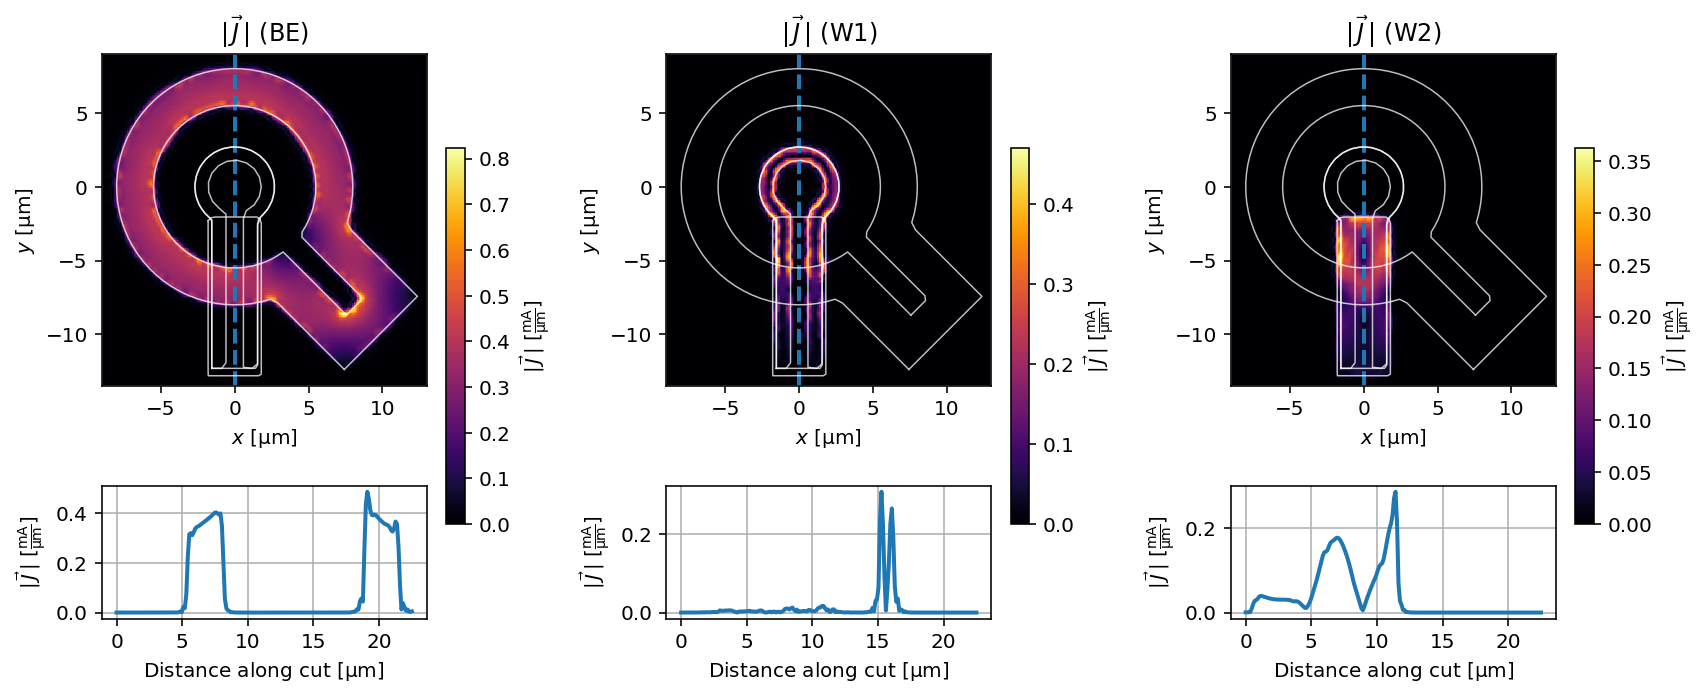

In [13]:
for solution in solutions[1:4]:
    fig, axes = sc.plot_currents(
        solution,
        figsize=(12,5),
        streamplot=False,
        units="mA/um",
        cross_section_xs=0,
        cross_section_angle=0,
    )
    for ax in axes:
        device.plot_polygons(ax=ax, legend=False, color='w', lw=0.75, alpha=0.75)

In [14]:
img = plt.imread("huber-image.png")
scale = np.where(img[385][:,0] == 1)[0].size / 5 # pixels per micron

origin = x0, y0 = (465, 610)

In [15]:
polygons = {name: scale * rotate(points, 0) for name, points in huber_geometry(interp_points=101).items()}

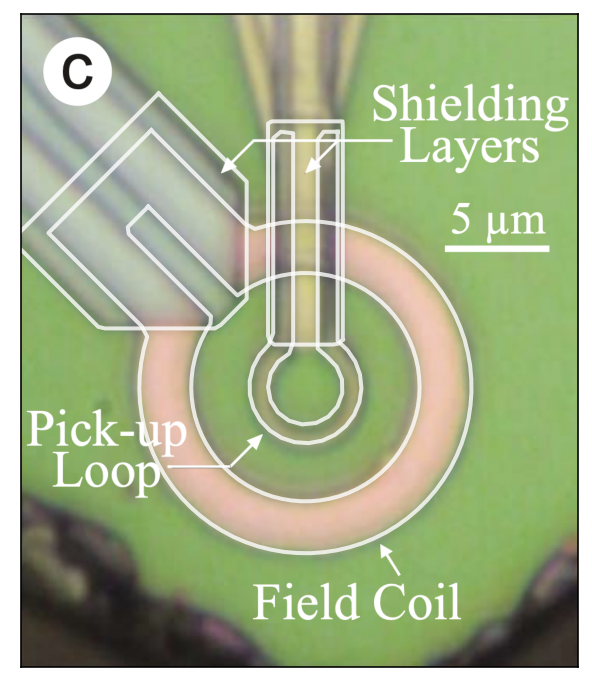

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect("equal")
im = ax.imshow(img[:-200])
ax.set_yticks([])
ax.set_xticks([])

for name, points in polygons.items():
    if name in ["pl_hull"]:
        continue
    xs, ys = points.T
    xs = -xs
    xs = xs + x0
    ys = ys + y0
    ax.plot(xs, ys, color='w', alpha=0.8, lw=2)
    
_ = ax.set_xlim(0, img.shape[1]-1)